<a href="https://colab.research.google.com/github/JacopoKahl/autoencoder_colorizer/blob/main/Autoencoder_Colorizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Colorizer Autoencoder

Sequential Autoencoder on the CIFAR10 dataset.

The autoencoder will learn to colorize grayscale images.

This time the input will be grayscale images and the output the respective color version.

Since data is more complex than the MNIST dataset, a latent space of 128 or more is suggested.

##Imports

Import libraries and functions

In [11]:
#Keras imports
from keras.models import Sequential #Sequential model class
from keras.layers import Dense, Flatten, Conv2D, Conv2DTranspose, Reshape

import numpy as np #numerical library numpy

#Import dataset
from keras.datasets import cifar10 #cifar10 color images dataset with 10 clases

#Visualization
import matplotlib.pyplot as plt #visualization library

##Load dataset

In [12]:
#Load train and test data
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

##Checking dataset

In [13]:
print('Dimensioni input training set: ', X_train.shape)
print('Dimensioni output training set: ', Y_train.shape)

print('Dimensioni input training set: ', X_test.shape)
print('Dimensioni output training set: ', Y_test.shape)

Dimensioni input training set:  (50000, 32, 32, 3)
Dimensioni output training set:  (50000, 1)
Dimensioni input training set:  (10000, 32, 32, 3)
Dimensioni output training set:  (10000, 1)


Label:  [6]


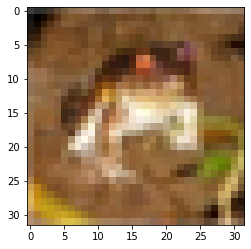

In [14]:
#Peeking into the training set

index = 0

plt.imshow(X_train[index], cmap='gray') #Show input image at index with grayscale colormap
print('Label: ', Y_train[index])

##Pre-processing the dataset



###Create grayscale and color datasets

In [15]:
#Create copy of training and test set
#X_train_color = np.copy(X_train) - this is not a real copy operation for complex variables. This means having another name (alias) for the same object
X_train_color = np.copy(X_train) #this is a real copy of the original training set
X_test_color = np.copy(X_test) #this is a real copy of the original test set

print('Color train images shape: ', X_train_color.shape)
print('Color test images shape: ', X_test_color.shape)

Color train images shape:  (50000, 32, 32, 3)
Color test images shape:  (10000, 32, 32, 3)


In [16]:
#Create grayscale version of the training and test set
X_train_gray = X_train_color[:, :, :, 0] #let's take only one channel of the (e.g. red component) of the color images
X_test_gray = X_test_color[:, :, :, 0] #let's take only one channel of the (e.g. red component) of the color images

print('Grayscale train images shape: ', X_train_gray.shape)
print('Grayscale test images shape: ', X_test_gray.shape)

Grayscale train images shape:  (50000, 32, 32)
Grayscale test images shape:  (10000, 32, 32)


##Normalize images

In [17]:
#X_train = X_train.astype('float32') /255 #casting to float and normalizing input in the [0,1] interval
#X_test = X_test.astype('float32') /255 #casting to float and normalizing input in the [0,1] interval

X_train_color = X_train_color.astype('float32') / 255 #casting to float and normalizing input in the [0,1] interval
X_test_color = X_test_color.astype('float32') / 255 #casting to float and normalizing input in the [0,1] interval

X_train_gray = X_train_gray.astype('float32') / 255 #casting to float and normalizing input in the [0,1] interval
X_test_gray = X_test_gray.astype('float32') / 255 #casting to float and normalizing input in the [0,1] interval

##Forcin input data dimensions

(#samples, witdh, height, #channels) format

In [18]:
X_train_gray = np.reshape(X_train_gray, X_train_gray.shape + (1,))
X_test_gray = np.reshape(X_test_gray, X_test_gray.shape + (1,))

print('Grayscale train images shape: ', X_train_gray.shape)
print('Grayscale test images shape: ', X_test_gray.shape)

Grayscale train images shape:  (50000, 32, 32, 1)
Grayscale test images shape:  (10000, 32, 32, 1)


##Autoencoder model

###Network structure

In [20]:
inShape = X_train_gray.shape[1:] #single input (one image) dimensions
print('Input shape: ', inShape)

latent_dim = 128 #Latent space dimension: 2D is easy to visualize, for better reconstruction performance try 256

Input shape:  (32, 32, 1)


## Encoder

Encoder network that creates representation in the latent space for input images.

In [21]:
encoder = Sequential() #instance of the Sequential class

encoder.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu', input_shape= inShape))
encoder.add(Conv2D(filters=64, kernel_size=3, strides=2, padding='same', activation='relu'))
encoder.add(Conv2D(filters=64, kernel_size=3, strides=2, padding='same', activation='relu'))
encoder.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))

encShapeBeforeFlatten = encoder.output_shape[1:] #save dimensions of output feature map before flattening
print('Encoder output shape before flatten: ', encShapeBeforeFlatten)

encoder.add(Flatten()) #flatten 2D output from previous layer into a 1D array

encoder.add(Dense(units=latent_dim, name='Latent_vector')) #NO activation!

encoder.summary()

Encoder output shape before flatten:  (8, 8, 64)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
Latent_vector (Dense)        (None, 128)               524416    
Total params: 617,088
Trainable params: 617,088
Non-trainable params: 0
_

##Decoder

The deoder network reconstructs an image from vector in latent space.

In [28]:
decoder = Sequential()

decoder.add(Dense(units=np.prod(encShapeBeforeFlatten), input_dim=latent_dim)) 
decoder.add(Reshape(encShapeBeforeFlatten)) #reshape input into encShapeBeforeFlatten resolution
decoder.add(Conv2DTranspose(filters=64, kernel_size=3, strides=1, activation='relu', padding='same'))
decoder.add(Conv2DTranspose(filters=64, kernel_size=3, strides=2, activation='relu', padding='same'))
decoder.add(Conv2DTranspose(filters=32, kernel_size=3, strides=2, activation='relu', padding='same'))
decoder.add(Conv2DTranspose(filters=3, kernel_size=3, strides=1, activation='sigmoid', padding='same')) #3 filters since output images need to be with 3 channels

print(decoder.output_shape)
decoder.summary()

(None, 32, 32, 3)
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 4096)              528384    
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 8, 8, 64)          36928     
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 16, 16, 64)        36928     
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 32, 32, 32)        18464     
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 32, 32, 3)         867       
Total params: 621,571
Trainable params: 621,571
Non-trainable params: 0
______________________________

##Autoencoder

In [29]:
autoencoder = Sequential()

autoencoder.add(encoder)
autoencoder.add(decoder)

autoencoder.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 128)               617088    
_________________________________________________________________
sequential_3 (Sequential)    (None, 32, 32, 3)         621571    
Total params: 1,238,659
Trainable params: 1,238,659
Non-trainable params: 0
_________________________________________________________________


In [30]:
#Specify loss function and optimizer
#autoencoder.compile(loss='binary_crossentropy', optimizer='adam')
autoencoder.compile(loss='mse', optimizer='adam') #mean squared error loss fuction and adam optimizer

##Training process

In [31]:
autoencoder.fit(X_train_gray, X_train_color, epochs=10, batch_size=32, validation_data=(X_test_gray, X_test_color))

Epoch 1/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.0151 - val_loss: 0.0141
Epoch 2/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0128 - val_loss: 0.0141
Epoch 3/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0124 - val_loss: 0.0140
Epoch 4/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.0121 - val_loss: 0.0141
Epoch 5/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.0118 - val_loss: 0.0144
Epoch 6/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0115 - val_loss: 0.0141
Epoch 7/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0113 - val_loss: 0.0140
Epoch 8/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0111 - val_loss: 0.0141
Epoch 9/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0109 - val_loss: 0.0147
Epoch 10/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.

##Visualization

In [32]:
#Generate output images corresponding to test input images

colorizedImages = autoencoder.predict(X_test_gray)

print(colorizedImages.shape)

(10000, 32, 32, 3)


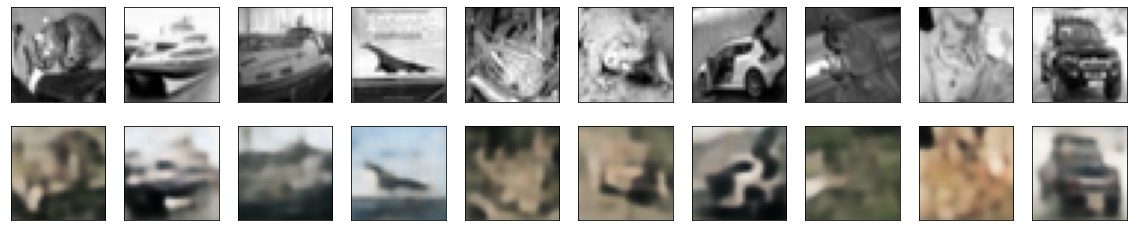

In [33]:
#The following coder plots a figure made of 10 images per row on two rows

n = 10 #number of subfigures per row

plt.figure(figsize=(20,4)) #total figure size in inches

for i in range(n): #for i in the range [0, n]
  #display original test images
  ax = plt.subplot(2, n, i+1) #create placeholder for the i-th image (plt works with index starting with 1 not 0)
  plt.imshow(X_test_gray[i].reshape(inShape[:2]), cmap='gray') #show i-th image
  ax.get_xaxis().set_visible(False) #disable x axis visibility
  ax.get_yaxis().set_visible(False) #disable y axis visibility

  #display reconstructed test images
  ax = plt.subplot(2, n, i+1+n) #create placeholder for the i-th image (plt works with index starting with 1 not 0)
  plt.imshow(colorizedImages[i].reshape(colorizedImages.shape[1:])) #show i-th image
  ax.get_xaxis().set_visible(False) #disable x axis visibility
  ax.get_yaxis().set_visible(False) #disable y axis visibility

plt.show() #display entire image

##Show the latent space

Visualize the 2D vectors (points in a 2D space) generated by the encoder to represent test images.

In [34]:
X_train_encoded = encoder.predict(X_train_gray) #create encoded vectors (embeddings) for input images using only the encoder model

print(X_train_encoded.shape)

(50000, 128)


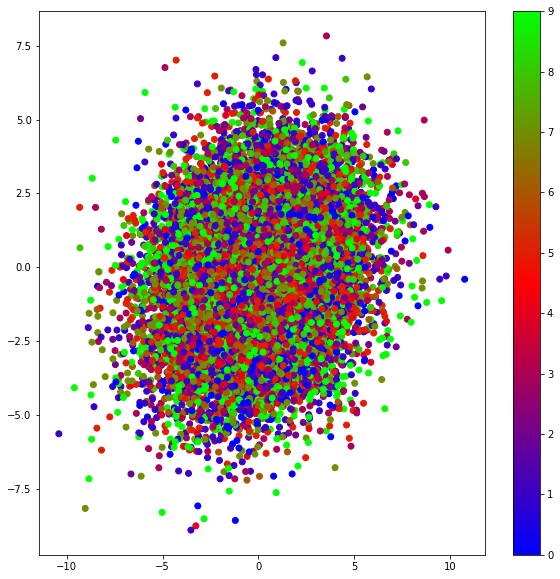

In [35]:
plt.figure(figsize=(10,10)) #figure of 10 inches
plt.scatter(X_train_encoded[:, 0], X_train_encoded[:, 1], c=Y_train, cmap='brg') #scatter plot of embeddings of test images
plt.colorbar()
plt.show()

Notice how the latent vectors for the different digits are clustered. Some clusters are large while some others are very compact. Notice how the clusters of 4 and 9 are overlapping, thus causing the reconstruction errors experienced in the previous visualization.